# Quantum Amplitude Estimation of risk models
For banks and insurances, modelling and assessing the business risk is an important task. A simple yet useful risk model was introduced and analyzed in the following article:

M. C. Braun, T. Decker, N. Hegemann, S. F. Kerstan, C. Schäfer: A Quantum Algorithm for the Sensitivity Analysis of Business Risks, [arXiv:2103.05475](https://arxiv.org/abs/2103.05475).

In this model, there are risk items like banks or companies with an associated probability of going bankrupt. These risk items are represented by nodes of a graph. The edges of the graph are the dependencies between the risk items: The bankruptcy of one risk item can lead to the bankruptcy of another risk item with a specified probability. In the following graph, a simple risk model with five risk items and several dependencies between them is shown:

```{image} ../images/riskModel.png
:alt: An example for a risk model
:width: 350px
:align: center
```
In this diagram, the probability $p_x$ is the probabilities that the corresponding node goes bankrupt and the probability $p_{xy}$ is the probability that the bankruptcy of node $x$ leads to the bankruptcy of node $y$.

A risk model can be used to determine the probabilities of critical events like a loss, which goes beyond a pre-defined threshold. In many cases, risk models have a big number of risk items and many dependencies between them. This makes the analysis of some properties of such models a computationally hard task. To tackle such problems, a quantum version of such a risk model was developed and analyzed in the article cited above. To support and facilitate the development of quantum algorithms for evaluating such risk models, geqo is equipped with the `RiskModel` function to automatically convert a risk model to its quantum version.

The quantum version of a model is based on an efficient encoding, which uses one qubit per risk item. The probabilities and dependencies between the risk items are modelled by uncontrolled and controlled rotations, respectively. This efficient representation of risk models enables the evaluation of the risk model with the Grover algorithm and with Quantum Amplitude Estimation (QAE).

In the following, an example for a risk model is constructed with the geqo function ```RiskModel``` and the probability of an event is estimated with QAE.

## Definition of the risk model

As example, we consider the risk model from above with five risk items. In the dictionary ```probsNodes``` a probability is assigned to each nodes. This probability is the probability of a node to fail, e.g. the probability that a company goes bankrupt. The dictionary ```probsEdges``` contains edges with probability values. Each edge represents the probability that the failure of the first node in the edge causes the failure of the second node.  

In [1]:
# defining the model
probsNodes = {
    "A": 0.9,
    "B": 0.9,
    "C": 0.9,
    "D": 0.9,
    "E": 0.9,
}  # intrinsic probabilities
probsEdges = {
    ("A", "B"): 0.1,
    ("A", "C"): 0.1,
    ("C", "D"): 0.5,
    ("C", "E"): 0.5,
}  # transition probabilities

With the geqo function ```RiskModel``` we can create a ```Sequence```, which represents the quantum circuit corresponding to the risk model. This means that after running the circuit, the probability of measuring a configuration of failed or non-failed risk items corresponds exactly to the probability of this case. For instance, the probability for measuring the result 11111 is 0.6726 and this is the probability in the risk model that all risk items fail.

The function ```RiskModel``` returns a ```Sequence``` along with a dictionary of definitions of the ```BasicGates```, which are used in the quantum circuit to set the values in the simulators.

In [2]:
from geqo.algorithms import RiskModel

seq, cv = RiskModel(node_probs=probsNodes, edge_probs=probsEdges)
print("The Sequence corresponding to the risk model:")
print()
print(seq)
print()
for c in cv:
    print("Definition of", c, ":")
    display(cv[c])

The Sequence corresponding to the risk model:

Sequence(['0', '1', '2', '3', '4'], [], [(BasicGate("ry(2.498091544796509)", 1), ['0'], []), (BasicGate("ry(2.498091544796509)", 1), ['1'], []), (QuantumControl([1], BasicGate("ry(0.034115800762489545)", 1)), ['0', '1'], []), (BasicGate("ry(2.498091544796509)", 1), ['2'], []), (QuantumControl([1], BasicGate("ry(0.034115800762489545)", 1)), ['0', '2'], []), (BasicGate("ry(2.498091544796509)", 1), ['3'], []), (QuantumControl([1], BasicGate("ry(0.19247429699702145)", 1)), ['2', '3'], []), (BasicGate("ry(2.498091544796509)", 1), ['4'], []), (QuantumControl([1], BasicGate("ry(0.19247429699702145)", 1)), ['2', '4'], [])])

Definition of ry(2.498091544796509) :


Matrix([
[0.316227766016838, -0.948683298050514],
[0.948683298050514,  0.316227766016838]])

Definition of ry(0.034115800762489545) :


Matrix([
[ 0.999854517544953, -0.0170570731648131],
[0.0170570731648131,   0.999854517544953]])

Definition of ry(0.19247429699702145) :


Matrix([
[ 0.995372778564001, -0.0960886657924843],
[0.0960886657924843,   0.995372778564001]])

The model and the definition of the gates can be used to directly run the circuit on a simulator. In the following example, the SymPy based simulator is used to calculate the density matrix of the quantum system after applying the model. We display the entries on the diagonal of the density matrix, which are higher than 0.05; these entries correspond to the probability of measuring the corresponding result.

In [3]:
from geqo.simulators import ensembleSimulatorSymPy
from geqo.utils import num2bin

sim = ensembleSimulatorSymPy(len(seq.qubits), 0)
for c in cv:
    sim.setValue(c, cv[c])
# print(sim.dict)
sim.apply(seq, [int(x) for x in seq.qubits])
# sim.printQASM()

for r in sim.ensemble:
    res = sim.ensemble[r]
    print("-" * 20)
    print("r=", r, "has prob.", res[0])
    # display(res[1])
    for xi in range(len(sim.ensemble[()][1].diagonal())):
        x = sim.ensemble[()][1].diagonal()[xi]
        if x > 0.05:
            print(num2bin(xi, 5), x)

--------------------
r= () has prob. 1
[0, 1, 1, 1, 1] 0.0731025000000000
[1, 0, 1, 1, 1] 0.0665232749999999
[1, 1, 0, 1, 1] 0.0597050999999999
[1, 1, 1, 1, 1] 0.672624224999999


The last entry corresponds to the failure off all nodes and the corresponding probability of this event is $0.6726$.

## Construction of the Grover operator
The Grover operator is composed as $G=-R_Y(a) S_0 R_Y(-a) S_x$, where $S_0$ and $S_x$ are phase operations. More precisely, $S_0$ multiplies the state $|00000\rangle$ with the phase $-1$ and all other states with the trivial phase $1$. In a similar way, $S_x$ marks the state $|11111\rangle$ with $-1$, for which we search the corresponding probability.

In [4]:
from geqo.operations import QuantumControl
from geqo.gates import PauliX, PauliZ
from geqo.core import Sequence

seqList = [
    (
        QuantumControl([1, 1, 1, 1], PauliZ()),
        ["0", "1", "2", "3", "4"],
        [],
    ),  # mark 11111 state
    (seq.getInverse(), ["0", "1", "2", "3", "4"], []),  # inverse operator
    (PauliX(), ["0"], []),  # the global -1
    (PauliZ(), ["0"], []),
    (PauliX(), ["0"], []),
    (PauliZ(), ["0"], []),
    (PauliX(), ["0"], []),  # Phase -1 on 0000 only, 1 else
    (QuantumControl([0, 0, 0, 0], PauliZ()), ["1", "2", "3", "4", "0"], []),
    (PauliX(), ["0"], []),
    (seq, ["0", "1", "2", "3", "4"], []),  # the operator
]

grov = Sequence(seq.qubits, seq.bits, seqList)  # Create the Grover operator as Sequence

## Construction of the QAE circuit

For the QAE algorithm, we need the powers $G, G^2, G^4, \ldots$ of the Grover operator. These powers are defined iteratively in the following.

In [5]:
pow1 = Sequence(["0", "1", "2", "3", "4"], [], [(grov, ["0", "1", "2", "3", "4"], [])])
pow2 = Sequence(
    ["0", "1", "2", "3", "4"],
    [],
    [(pow1, ["0", "1", "2", "3", "4"], []), (pow1, ["0", "1", "2", "3", "4"], [])],
)
pow4 = Sequence(
    ["0", "1", "2", "3", "4"],
    [],
    [(pow2, ["0", "1", "2", "3", "4"], []), (pow2, ["0", "1", "2", "3", "4"], [])],
)
pow8 = Sequence(
    ["0", "1", "2", "3", "4"],
    [],
    [(pow4, ["0", "1", "2", "3", "4"], []), (pow4, ["0", "1", "2", "3", "4"], [])],
)
pow16 = Sequence(
    ["0", "1", "2", "3", "4"],
    [],
    [(pow8, ["0", "1", "2", "3", "4"], []), (pow8, ["0", "1", "2", "3", "4"], [])],
)
pow32 = Sequence(
    ["0", "1", "2", "3", "4"],
    [],
    [(pow16, ["0", "1", "2", "3", "4"], []), (pow16, ["0", "1", "2", "3", "4"], [])],
)
pow64 = Sequence(
    ["0", "1", "2", "3", "4"],
    [],
    [(pow32, ["0", "1", "2", "3", "4"], []), (pow32, ["0", "1", "2", "3", "4"], [])],
)

With the defined sequences, we can create the full circuit for the QAE. The qubits ```0``` to ```4``` are the working space for the risk model circuit and the Grover operators. The qubits ```p0``` to ```p6``` are initialized with a Hadamard transform and each is used for a phase kickback from a power of the Grover operator. At the end, an inverse QFT is applied to these qubits and they are measured in the standard basis. The result is a binary representation of the estimation of the probability, which corresponds to the event that all risk items have failed, i.e. the probability for measuring the state is $|11111\rangle$.

In [6]:
from geqo.gates import Hadamard
from geqo.operations import QuantumControl
from geqo.algorithms import InverseQFT

qft = InverseQFT(7)
gatesAndTargets = []
gatesAndTargets.append((Hadamard(), ["p0"], []))
gatesAndTargets.append((Hadamard(), ["p1"], []))
gatesAndTargets.append((Hadamard(), ["p2"], []))
gatesAndTargets.append((Hadamard(), ["p3"], []))
gatesAndTargets.append((Hadamard(), ["p4"], []))
gatesAndTargets.append((Hadamard(), ["p5"], []))
gatesAndTargets.append((Hadamard(), ["p6"], []))
gatesAndTargets.append((seq, ["0", "1", "2", "3", "4"], []))
gatesAndTargets.append(
    (QuantumControl([1], pow64), ["p0", "0", "1", "2", "3", "4"], [])
)
gatesAndTargets.append(
    (QuantumControl([1], pow32), ["p1", "0", "1", "2", "3", "4"], [])
)
gatesAndTargets.append(
    (QuantumControl([1], pow16), ["p2", "0", "1", "2", "3", "4"], [])
)
gatesAndTargets.append((QuantumControl([1], pow8), ["p3", "0", "1", "2", "3", "4"], []))
gatesAndTargets.append((QuantumControl([1], pow4), ["p4", "0", "1", "2", "3", "4"], []))
gatesAndTargets.append((QuantumControl([1], pow2), ["p5", "0", "1", "2", "3", "4"], []))
gatesAndTargets.append((QuantumControl([1], pow1), ["p6", "0", "1", "2", "3", "4"], []))
gatesAndTargets.append((qft, ["p0", "p1", "p2", "p3", "p4", "p5", "p6"], []))
seq2 = Sequence(
    ["p0", "p1", "p2", "p3", "p4", "p5", "p6", "0", "1", "2", "3", "4"],
    [],
    gatesAndTargets,
)

## A function for evaluating the results of QAE

The output of the QAE is an estimation of the probability in binary format. We define the function, which calculates the probability values corresponding to the binary outputs.

In [7]:
from geqo.utils import bin2num


def bit2prob(bits):
    summe = bin2num(bits)
    res = summe / 2 ** (len(bits) - 1)
    theta_estim = math.pi * res / 2.0
    prob_estim = math.sin(theta_estim) * math.sin(theta_estim)
    return prob_estim

The probability values corresponding to the possible binary results are not evenly distributed in the intervall $[0,1]$. The following values and the plot shows that the values are denser around $0$ and $1$ in contrast to $0.5$. 

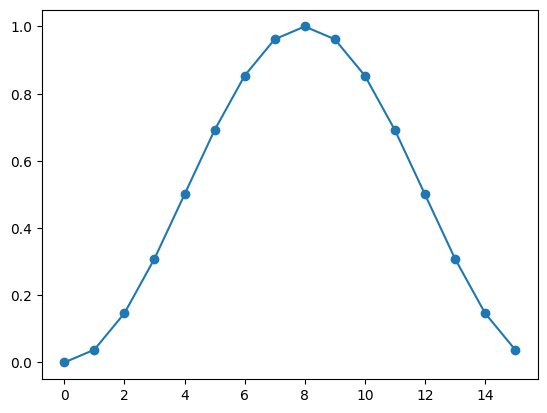

In [8]:
import itertools
import math
import matplotlib.pyplot as plt

xe2 = []
ye2 = []
for i in itertools.product([0, 1], repeat=4):
    xe2.append(bin2num(i))
    ye2.append(bit2prob(i))
plt.scatter(xe2, ye2)
plt.plot(xe2, ye2)

## Running the QAE

In the following, we use the NumPy based simulator ```simulatorStatevectorNumpy```. Before we can run the QAE circuit and apply the measurements, the simulator has to be prepared with the methods ```setValue``` and ```prepareBackend```. Since the ```RiskModel``` function returns matrix definitions in SymPy, we have to convert these matrices to NumPy with the function ```matrix2numpy```.

In [9]:
from sympy import matrix2numpy
from geqo.operations import Measure
from geqo.simulators.numpy import simulatorStatevectorNumpy

sim = simulatorStatevectorNumpy(12, 7)
for c in cv:
    print("setting c=", c)
    sim.setValue(c, matrix2numpy(cv[c], dtype=float))
sim.prepareBackend([qft])

sim.apply(seq2, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [])
sim.apply(Measure(7), [0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6])

setting c= ry(2.498091544796509)
setting c= ry(0.034115800762489545)
setting c= ry(0.19247429699702145)


## Results of the QAE

The possible results of the measurement along with their corresponding probabilities are shown in the following. The results of the function ```bit2prob``` above shows that several binary results might correspond to the same probability estimation. Note that we only display results that have more than $1\%$ probability.

In [10]:
te = {}
for ex in sim.measurementResult:
    e = [int(i) for i in list(ex)]
    estim = round(bit2prob(e), 5)
    prob = sim.measurementResult[ex]
    if prob > 0.01:
        print(
            "binary result: "
            + str(ex)
            + ", estimation: "
            + str(estim)
            + ", probability of this result: "
            + str(prob)
        )
    if estim in te:
        te[estim] += prob
    else:
        te[estim] = prob

binary result: (0, 1, 0, 0, 1, 1, 0), estimation: 0.64514, probability of this result: 0.010556852174544506
binary result: (0, 1, 0, 0, 1, 1, 1), estimation: 0.66844, probability of this result: 0.44831596084009684
binary result: (0, 1, 0, 1, 0, 0, 0), estimation: 0.69134, probability of this result: 0.02195105107156827
binary result: (1, 0, 1, 1, 0, 0, 0), estimation: 0.69134, probability of this result: 0.02195105107156827
binary result: (1, 0, 1, 1, 0, 0, 1), estimation: 0.66844, probability of this result: 0.44831596084009684
binary result: (1, 0, 1, 1, 0, 1, 0), estimation: 0.64514, probability of this result: 0.010556852174544508


The following plot shows the probability for each possible estimation of the probability of the event that all risk items have failed.

result of QAE with highest probability: 0.66844
probability of this result: 0.8966319216801937


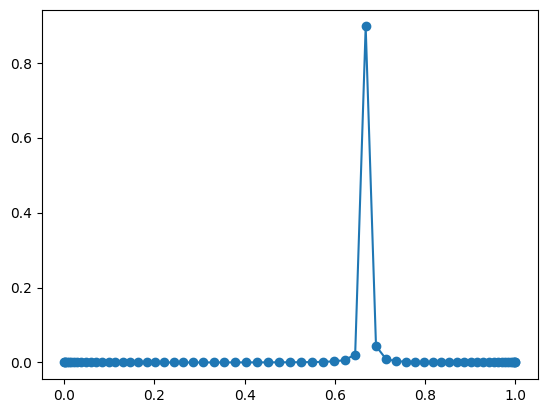

In [11]:
import matplotlib.pyplot as plt

xe = []
ye = []
maxIndex = 0
maxValue = 0
for t in te:
    xe.append(t)
    ye.append(te[t])
    if te[t] > maxValue:
        maxIndex = t
        maxValue = te[t]
# print(te)
print("result of QAE with highest probability:", maxIndex)
print("probability of this result:", maxValue)
plt.plot(xe, ye)
plt.scatter(xe, ye)

The result with the highest probability corresponds to the probability value $0.66844$, which is the closest approximation to the probability $0.6726$ for this level of precision. The probability of measuring this best approximation is over $80\%$, i.e., the result can usually be found with two or three executions of the QAE circuit. The following diagram shows the concentration of the probability on the closest applroximation.